# Importation des Images et cration du jeu de données

In [1]:
# pip install -r requierments.txt

## Importations des packages

In [77]:
# Importation des packages
import os
from PIL import Image
import cv2
import numpy as np

# Imporattion des packages sklearn pour knn et svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.svm import SVC

# Pour les graphique
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

# PyTorch pour cnn et augmentation d'images
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import v2
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

## Enhance Data

In [78]:
def add_gaussian_noise(img, mean = 0, std = 25):

    img=np.array(img)

    noise = np.random.normal(mean, std, img.shape).astype(np.uint8)
    noisy_img = cv2.add(img, noise)

    return noisy_img

In [107]:
def img_data_augmentation(img_file, folder_path):

    img = Image.open('flags/%s.png'%img_file).convert('RGB')
    img.thumbnail((512,512))

    bright_transformer = v2.ColorJitter(brightness=1, contrast=1, saturation=0.4)
    rotation_transformer = v2.RandomRotation(degrees=(-20,20))
    blur_transformer = v2.GaussianBlur(kernel_size=15, sigma=(0.1, 5))
    perspective_transformer = v2.RandomPerspective(distortion_scale=0.5, p=1)
    wave_transformer = v2.ElasticTransform(alpha=125)
    
    for i in range(1,11):

        std = round(10**(i/5))
        noise=add_gaussian_noise(img,0,std)
        noise=Image.fromarray(noise)
        noise.save(f'{folder_path}/{img_file}_noise_{i}.png')
        noise_bright = bright_transformer(noise)
        noise_bright.save(f'{folder_path}/{img_file}_noise_bright_{i}.png')
        noise_rota = rotation_transformer(noise)
        noise_rota.save(f'{folder_path}/{img_file}_noise_rota_{i}.png')
        noise_blur = blur_transformer(noise)
        noise_blur.save(f'{folder_path}/{img_file}_noise_blur_{i}.png')
        noise_per = perspective_transformer(noise)
        noise_per.save(f'{folder_path}/{img_file}_noise_per_{i}.png')
        noise_wave = wave_transformer(noise)
        noise_wave.save(f'{folder_path}/{img_file}_noise_wave_{i}.png')

        bright = bright_transformer(img)
        bright.save(f'{folder_path}/{img_file}_bright_{i}.png')
        bright_rota = rotation_transformer(bright)
        bright_rota.save(f'{folder_path}/{img_file}_bright_rota_{i}.png')
        bright_blur = blur_transformer(bright)
        bright_blur.save(f'{folder_path}/{img_file}_bright_blur_{i}.png')
        bright_per = perspective_transformer(bright)
        bright_per.save(f'{folder_path}/{img_file}_bright_per_{i}.png')
        bright_wave = wave_transformer(bright)
        bright_wave.save(f'{folder_path}/{img_file}_bright_wave_{i}.png')

        rota = rotation_transformer(img)
        rota.save(f'{folder_path}/{img_file}_rota_{i}.png')
        rota_blur = blur_transformer(rota)
        rota_blur.save(f'{folder_path}/{img_file}_rota_blur_{i}.png')
        rota_per = perspective_transformer(rota)
        rota_per.save(f'{folder_path}/{img_file}_rota_per_{i}.png')
        rota_wave = wave_transformer(rota)
        rota_wave.save(f'{folder_path}/{img_file}_rota_wave_{i}.png')

        blur = blur_transformer(img)
        blur.save(f'{folder_path}/{img_file}_blur_{i}.png')
        blur_per = perspective_transformer(blur)
        blur_per.save(f'{folder_path}/{img_file}_blur_per_{i}.png')
        blur_wave = wave_transformer(blur)
        blur_wave.save(f'{folder_path}/{img_file}_blur_wave_{i}.png')

        per = perspective_transformer(img)
        per.save(f'{folder_path}/{img_file}_per_{i}.png')
        per_wave = wave_transformer(per)
        per_wave.save(f'{folder_path}/{img_file}_per_wave_{i}.png')

        wave = wave_transformer(img)
        wave.save(f'{folder_path}/{img_file}_wave_{i}.png')

## Create Dataset

In [109]:
FLAG_LIST_DIR = 'flag_list.txt'
DATASET_DIR = 'C:/Users/paulz/Desktop/projet_master/input_data'

with open(FLAG_LIST_DIR, 'r') as f:
    flags = [line[:-1] for line in f]

selected_flags = np.random.choice(flags,10)
# selected_flags = ['hr','lu','nl','py','rs','ru','si','sk','','cr','th'] #liste de drapeaux similaires bleu/blanc/rouge horizontal
# selected_flags = ['bb','fi','gq','id','jm','ma','ng','ni','tn','uy']
# Crée ou détruit le dossier d'inputs
if not os.path.exists(DATASET_DIR):
    os.makedirs(DATASET_DIR)       

    for flag in selected_flags:

        flag_dir = '{0}/{1}'.format(DATASET_DIR,flag)

        if os.path.exists(flag_dir) == False:
            os.makedirs(flag_dir)

            img_data_augmentation(flag, flag_dir)

else:
    print('Input Folder already exists.')

Input Folder already exists.


# KNN Classification

In [82]:
def load_images(input_dir):
    images = []
    labels = []

    for folder in os.listdir(input_dir):

        label_folder = os.path.join(input_dir, folder)
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                img_path = os.path.join(label_folder, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    images.append(img)
                    labels.append(folder)
    return images, labels

images, labels = load_images(DATASET_DIR)
print(len(images), labels)

2100 ['bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb', 'bb'

In [83]:
def preprocess_images(images, size=(64, 64)):
    preprocessed_images = []
    for img in images:
        # Resize image
        resized_img = cv2.resize(img, size)
        # Flatten the image
        flattened_img = resized_img.flatten()
        preprocessed_images.append(flattened_img)
    return np.array(preprocessed_images)

In [166]:
images, labels = load_images(DATASET_DIR)
images = preprocess_images(images, (32 ,32))
labels = np.array(labels)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
X_train, X_test, y_train, y_test = train_test_split(images,
                                                    encoded_labels,
                                                    test_size=0.2,
                                                    random_state=1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(X_test[0].shape)

(3072,)


In [168]:
# Paramètres pour le nombre de voisins
k_par = list(range(1, 31))
param_dict = {"n_neighbors": k_par,
              "weights": ["uniform", "distance"]}
n_cv = 4
# Recherche sur grille avec CV
knn_classifier = KNeighborsClassifier()
grid_search_knn = GridSearchCV(knn_classifier,
                                param_dict,
                                verbose=3,
                                cv=n_cv)
grid_search_knn.fit(X_train, y_train)

Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV 1/4] END ....n_neighbors=1, weights=uniform;, score=0.914 total time=   0.0s
[CV 2/4] END ....n_neighbors=1, weights=uniform;, score=0.924 total time=   0.0s
[CV 3/4] END ....n_neighbors=1, weights=uniform;, score=0.898 total time=   0.0s
[CV 4/4] END ....n_neighbors=1, weights=uniform;, score=0.910 total time=   0.0s
[CV 1/4] END ...n_neighbors=1, weights=distance;, score=0.914 total time=   0.0s
[CV 2/4] END ...n_neighbors=1, weights=distance;, score=0.924 total time=   0.0s
[CV 3/4] END ...n_neighbors=1, weights=distance;, score=0.898 total time=   0.0s
[CV 4/4] END ...n_neighbors=1, weights=distance;, score=0.910 total time=   0.0s
[CV 1/4] END ....n_neighbors=2, weights=uniform;, score=0.886 total time=   0.0s
[CV 2/4] END ....n_neighbors=2, weights=uniform;, score=0.898 total time=   0.0s
[CV 3/4] END ....n_neighbors=2, weights=uniform;, score=0.883 total time=   0.0s
[CV 4/4] END ....n_neighbors=2, weights=uniform

GridSearchCV(cv=4, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30],
                         'weights': ['uniform', 'distance']},
             verbose=3)

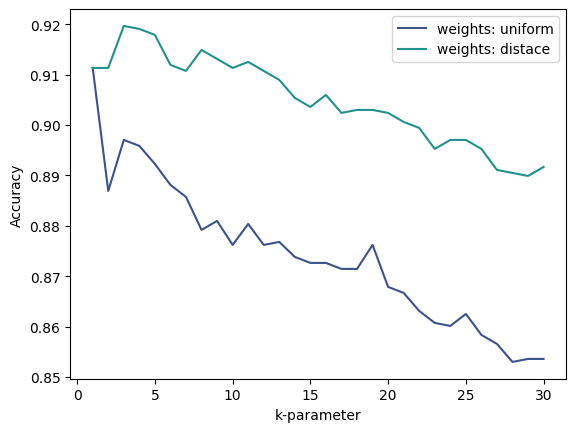

In [212]:
accuracy_uni = grid_search_knn.cv_results_['mean_test_score'][0::2]
accuracy_dist = grid_search_knn.cv_results_['mean_test_score'][1::2]

# diagramme k - accuracy
plt.plot(k_par, accuracy_uni, c='#3b528b', label = 'weights: uniform')
plt.plot(k_par, accuracy_dist, c='#21918c', label = 'weights: distace')
plt.xlabel('k-parameter')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [173]:
accuracy_knn_test = grid_search_knn.best_estimator_.score(X_test, y_test)
best_k = grid_search_knn.best_params_["n_neighbors"]
best_weights = grid_search_knn.best_params_["weights"]
print(f"kNN: meilleure paramètre k = {best_k}")
print(f"kNN: meilleure poids: {best_weights}")
print(f"kNN: meilleure exactitude d'entrainement = "
      f"{grid_search_knn.best_score_: .2%}")
print(f"kNN: meilleure exactitude de test = {accuracy_knn_test: .2%}")

kNN: meilleure paramètre k = 3
kNN: meilleure poids: distance
kNN: meilleure exactitude d'entrainement =  91.96%
kNN: meilleure exactitude de test =  93.10%


In [175]:
best_knn = KNeighborsClassifier(n_neighbors=best_k, weights=best_weights)
best_knn.fit(X_train, y_train)

y_knn_train = (best_knn.predict(X_train))
y_knn_test = (best_knn.predict(X_test))

#Calcul et affichage de l'exactitude
accuracy_knn_train = accuracy_score(y_train, y_knn_train)
accuracy_knn_test = accuracy_score(y_test, y_knn_test)
print(f'Exactitude: {accuracy_knn_train:.2%} (train) & {accuracy_knn_test:.2%}\
 (test)')

#Calcul et affichage de la precision
precision_knn_train = precision_score(y_train, y_knn_train,
                                      average='weighted')
precision_knn_test = precision_score(y_test, y_knn_test, 
                                     average='weighted')
print(f'Précision: {precision_knn_train:.2%} (train) & {precision_knn_test:.2%}\
 (test)')

#Calcul et affichage du rappel
recall_knn_train = recall_score(y_train, y_knn_train,
                                average='weighted')
recall_knn_test = recall_score(y_test, y_knn_test,
                               average='weighted')
print(f'Rappel: {recall_knn_train:.2%} (train) & {recall_knn_test:.2%} (test)')

#Calcul et affichage des scores f1
f1_knn_train = f1_score(y_train, y_knn_train,
                        average='weighted')
f1_knn_test = f1_score(y_test, y_knn_test, average='weighted')
print(f'Score F1: {f1_knn_train:.2%} (train) & {f1_knn_test:.2%} (test)')

Exactitude: 100.00% (train) & 93.10% (test)
Précision: 100.00% (train) & 93.57% (test)
Rappel: 100.00% (train) & 93.10% (test)
Score F1: 100.00% (train) & 93.12% (test)


# SVM

In [89]:
#paramètres du SVC
C = [0.1, 1, 10]
gamma_par = [round(i,3) for i in np.linspace(0.001, 1, 10)]
kernels = ['poly', 'rbf', 'sigmoid']

param_dict = {'C': C,
              'gamma': gamma_par, 
              'kernel': kernels}

#nombre de cv
n_cv = 4

#Cross-validation
svm_classifier = SVC()
grid_search_svm = GridSearchCV(svm_classifier,
                               param_dict,
                               cv=n_cv,
                               verbose = 3
                               )
grid_search_svm.fit(X_train, y_train)

Fitting 4 folds for each of 90 candidates, totalling 360 fits
[CV 1/4] END ...C=0.1, gamma=0.001, kernel=poly;, score=0.914 total time=   1.5s
[CV 2/4] END ...C=0.1, gamma=0.001, kernel=poly;, score=0.905 total time=   1.4s
[CV 3/4] END ...C=0.1, gamma=0.001, kernel=poly;, score=0.919 total time=   1.7s
[CV 4/4] END ...C=0.1, gamma=0.001, kernel=poly;, score=0.905 total time=   1.2s
[CV 1/4] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.829 total time=   3.9s
[CV 2/4] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.817 total time=   3.7s
[CV 3/4] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.850 total time=   4.0s
[CV 4/4] END ....C=0.1, gamma=0.001, kernel=rbf;, score=0.821 total time=   3.8s
[CV 1/4] END C=0.1, gamma=0.001, kernel=sigmoid;, score=0.686 total time=   2.2s
[CV 2/4] END C=0.1, gamma=0.001, kernel=sigmoid;, score=0.643 total time=   2.4s
[CV 3/4] END C=0.1, gamma=0.001, kernel=sigmoid;, score=0.590 total time=   2.0s
[CV 4/4] END C=0.1, gamma=0.001, kernel=sigmoid

GridSearchCV(cv=4, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10],
                         'gamma': [0.001, 0.112, 0.223, 0.334, 0.445, 0.556,
                                   0.667, 0.778, 0.889, 1.0],
                         'kernel': ['poly', 'rbf', 'sigmoid']},
             verbose=3)

[]

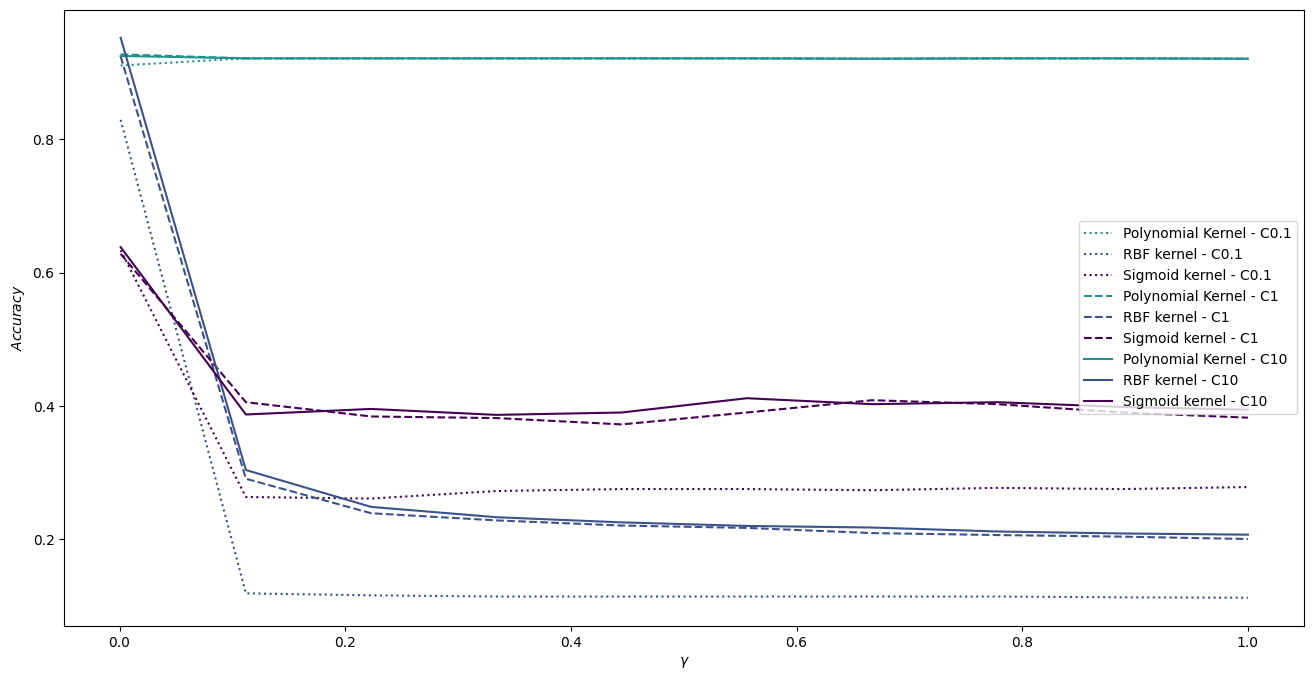

In [90]:
#exactitude moyenne par cv (renvoie une liste des scores avec les trois kernels)
accuracy = grid_search_svm.cv_results_['mean_test_score']

#récupération du score pour chaque kernel C=0.1
poly_accuracy_c1 = accuracy[0::3][0:10]
rbf_accuracy_c1 = accuracy[1::3][0:10]
sig_accuracy_c1 = accuracy[2::3][0:10]

#récupération du score pour chaque kernel C=1
poly_accuracy_c2 = accuracy[0::3][10:20]
rbf_accuracy_c2 = accuracy[1::3][10:20]
sig_accuracy_c2 = accuracy[2::3][10:20]

#récupération du score pour chaque kernel C=10
poly_accuracy_c3 = accuracy[0::3][20:30]
rbf_accuracy_c3 = accuracy[1::3][20:30]
sig_accuracy_c3 = accuracy[2::3][20:30]

#Graphique pour de l'exactitude en fonction de lambda
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(gamma_par, poly_accuracy_c1, c='#21918c', linestyle='dotted', label=f'Polynomial Kernel - C{C[0]}')
ax.plot(gamma_par, rbf_accuracy_c1, c="#3b528b", linestyle='dotted', label=f"RBF kernel - C{C[0]}")
ax.plot(gamma_par, sig_accuracy_c1, c="#440154", linestyle='dotted',label=f"Sigmoid kernel - C{C[0]}")

ax.plot(gamma_par, poly_accuracy_c2, c='#21918c', linestyle='dashed', label=f'Polynomial Kernel - C{C[1]}')
ax.plot(gamma_par, rbf_accuracy_c2, c="#3b528b", linestyle='dashed', label=f"RBF kernel - C{C[1]}")
ax.plot(gamma_par, sig_accuracy_c2, c="#440154", linestyle='dashed', label=f"Sigmoid kernel - C{C[1]}")

ax.plot(gamma_par, poly_accuracy_c3, c='#21918c', label=f'Polynomial Kernel - C{C[2]}')
ax.plot(gamma_par, rbf_accuracy_c3, c="#3b528b", label=f"RBF kernel - C{C[2]}")
ax.plot(gamma_par, sig_accuracy_c3, c="#440154", label=f'Sigmoid kernel - C{C[2]}')

ax.set_xlabel("$\gamma$")
ax.set_ylabel("$Accuracy$")
ax.legend()
plt.plot()

In [91]:
#Meilleurs paramètres et exactitude de la cv
print(f"SVM: meilleures paramètres: {grid_search_svm.best_params_}")
print(f"avec{grid_search_svm.best_score_: .2%} d'exactitude.\n")

#SVM avec les meilleurs paramètres
best_kernel = grid_search_svm.best_params_['kernel']
best_gamma = grid_search_svm.best_params_['gamma']
best_C = grid_search_svm.best_params_['C']

best_svm = SVC(C=best_C,kernel=best_kernel, gamma=best_gamma)
best_svm.fit(X_train, y_train)

outputs_svm_train = (best_svm.predict(X_train))
outputs_svm_test = (best_svm.predict(X_test))

#Calcul et affichage de l'exactitude
accuracy_svm_train = accuracy_score(y_train, outputs_svm_train)
accuracy_svm_test = accuracy_score(y_test, outputs_svm_test)
print(f'Exactitude: {accuracy_svm_train:.2%} (train) & {accuracy_svm_test:.2%}\
 (test)')

#Calcul et affichage de la precision
precision_svm_train = precision_score(y_train, outputs_svm_train,
                                      average='weighted')
precision_svm_test = precision_score(y_test, outputs_svm_test, 
                                     average='weighted')
print(f'Précision: {precision_svm_train:.2%} (train) & {precision_svm_test:.2%}\
 (test)')

#Calcul et affichage du rappel
recall_svm_train = recall_score(y_train, outputs_svm_train,
                                average='weighted')
recall_svm_test = recall_score(y_test, outputs_svm_test,
                               average='weighted')
print(f'Rappel: {recall_svm_train:.2%} (train) & {recall_svm_test:.2%} (test)')

#Calcul et affichage des scores f1
f1_svm_train = f1_score(y_train, outputs_svm_train,
                        average='weighted')
f1_svm_test = f1_score(y_test, outputs_svm_test, average='weighted')
print(f'Score F1: {f1_svm_train:.2%} (train) & {f1_svm_test:.2%} (test)')

SVM: meilleures paramètres: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
avec 95.24% d'exactitude.

Exactitude: 98.63% (train) & 94.29% (test)
Précision: 98.68% (train) & 94.84% (test)
Rappel: 98.63% (train) & 94.29% (test)
Score F1: 98.64% (train) & 94.38% (test)


# CNN

In [92]:
# Check si une carte graphique compatible est diponible
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [118]:
input_dataset = datasets.ImageFolder(root=DATASET_DIR,
                                     transform=transforms.Compose([
                                        transforms.Resize((32, 32)),
                                        transforms.ToTensor()]))

image_mean = torch.stack([t.mean(1).mean(1) for t, c in input_dataset]).mean(0)
image_std = torch.stack([t.std(1).std(1) for t, c in input_dataset]).mean(0)
print(f'mean: {image_mean}, std: {image_std}')

input_transform = transforms.Compose([transforms.Resize((32, 32)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=image_mean, std=image_std)])

input_dataset = datasets.ImageFolder(root=DATASET_DIR,
                                     transform = input_transform)

seed = torch.Generator().manual_seed(1)
train_dataset, valid_dataset = random_split(input_dataset, [0.8, 0.2], generator=seed)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

num_classes = len(input_dataset.classes)
print(num_classes)

mean: tensor([0.5116, 0.4417, 0.4458]), std: tensor([0.0748, 0.0705, 0.0626])
10


In [94]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.to(device)

c:\Users\paulz\Desktop\projet_master\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\paulz\Desktop\projet_master\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [100]:
CHECKPOINTS_DIR = "checkpoints"
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)

In [101]:
num_epochs = 20

for epoch in range(1,num_epochs+1):

  # ---- Entrainement

    model.train()
    train_loss = 0
    train_correct = 0
    for inputs, labels in train_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logit_outputs = model(inputs)
        loss = criterion(logit_outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (logit_outputs.argmax(1) == labels).sum().item()

    # ---- Validation

    model.eval()
    valid_loss = 0
    valid_correct = 0

    for inputs, labels in valid_loader:


        inputs = inputs.to(device)
        labels = labels.to(device)


        logit_outputs = model(inputs)
        loss = criterion(logit_outputs, labels)


        valid_loss += loss.item()
        valid_correct += (logit_outputs.argmax(1) == labels).sum().item()

    # Affichage 

    # Calcul de la perte moyenne et exactitude moyenne
    train_mean_loss = train_loss / len(train_loader.dataset)
    valid_mean_loss = valid_loss / len(valid_loader.dataset)
    train_mean_accuracy = train_correct / len(train_loader.dataset)
    valid_mean_accuracy = valid_correct / len(valid_loader.dataset)

    # Print
    print(f"Epoch {epoch}/{num_epochs} : "
              f"train loss = {train_mean_loss:.4f}, "
              f"train accuracy = {train_mean_accuracy:.3%}, "
              f"valid loss = {valid_mean_loss:.4f}, "
              f"valid accuracy = {valid_mean_accuracy:.3%}.")

    # Engistrement
    torch.save({"epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_tat_dict": optimizer.state_dict(),
                "train_loss": train_mean_loss,
                "valid_loss": valid_mean_loss,
                "train_accuracy": train_mean_accuracy,
                "valid_accuracy": valid_mean_accuracy}, 
               f"{CHECKPOINTS_DIR}/model_{epoch}.pt")
                                       

Epoch 1/20 : train loss = 0.0032, train accuracy = 97.024%, valid loss = 0.0020, valid accuracy = 98.095%.
Epoch 2/20 : train loss = 0.0037, train accuracy = 96.905%, valid loss = 0.0019, valid accuracy = 98.095%.
Epoch 3/20 : train loss = 0.0036, train accuracy = 96.548%, valid loss = 0.0023, valid accuracy = 97.857%.
Epoch 4/20 : train loss = 0.0033, train accuracy = 97.024%, valid loss = 0.0020, valid accuracy = 98.095%.
Epoch 5/20 : train loss = 0.0041, train accuracy = 96.905%, valid loss = 0.0020, valid accuracy = 98.095%.
Epoch 6/20 : train loss = 0.0036, train accuracy = 96.845%, valid loss = 0.0020, valid accuracy = 98.095%.
Epoch 7/20 : train loss = 0.0033, train accuracy = 96.964%, valid loss = 0.0018, valid accuracy = 98.095%.
Epoch 8/20 : train loss = 0.0037, train accuracy = 96.786%, valid loss = 0.0020, valid accuracy = 98.095%.
Epoch 9/20 : train loss = 0.0036, train accuracy = 96.667%, valid loss = 0.0018, valid accuracy = 98.095%.
Epoch 10/20 : train loss = 0.0035, tr

In [121]:
best_epoch = 2
best_checkpoint = torch.load(f"{CHECKPOINTS_DIR}/model_{best_epoch}.pt")
best_valid_accuracy = best_checkpoint["valid_accuracy"]
print(f"Validation accuracy = {best_valid_accuracy:.2%}")

Validation accuracy = 98.10%


In [119]:
TEST_DIR = 'C:/Users/paulz/Desktop/projet_master/input_data'
test_dataset = datasets.ImageFolder(root=TEST_DIR,
                                     transform=transforms.Compose([
                                        transforms.Resize((32, 32)),
                                        transforms.ToTensor()]))

test_dataset = datasets.ImageFolder(root=DATASET_DIR,
                                     transform = input_transform)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [120]:
model.eval()
model.to(device)

test_correct = 0
for inputs, labels in test_loader:
  inputs = inputs.to(device)
  labels = labels.to(device)
  logit_outputs = model(inputs)
  test_correct += (logit_outputs.argmax(1) == labels).sum().item()

test_accuracy = test_correct / len(test_loader.dataset)
print(f"Test Accuracy = {test_accuracy:.2%}:")

Test Accuracy = 97.71%:


In [233]:
# test_img = 'C:/Users/paulz/Desktop/projet_master/input_paint/ma_paint.png'
test_img = 'C:/Users/paulz/Desktop/projet_master/test_data/bb/bb_noise_bright_3.png'
img = Image.open(test_img).convert('RGB')
img_tensor = input_transform(img).unsqueeze(0)


logodd = model(img_tensor.to(device))
prob = torch.nn.functional.softmax(logodd, dim=1)[0]
_, indices = torch.sort(prob, descending=True)

iso = ['bb','fi','gq','id','jm','ma','ng','ni','tn','uy']
for i in indices:
  print(iso[i], f": {prob[i].item():.2%}")

ng : 89.87%
uy : 4.65%
fi : 1.95%
jm : 1.43%
ni : 0.46%
gq : 0.44%
tn : 0.37%
ma : 0.36%
bb : 0.31%
id : 0.15%


In [234]:
knn_img = cv2.imread(test_img)
knn_img = cv2.resize(knn_img, (32,32))
knn_img = knn_img.flatten()
knn_img = np.array([knn_img])
knn_img = scaler.transform(knn_img)
knn_prob = best_knn.predict_proba(knn_img)

for i,prob in enumerate(knn_prob[0]):
  print(iso[i], f": {prob:.2%}")

bb : 0.00%
fi : 0.00%
gq : 0.00%
id : 0.00%
jm : 56.63%
ma : 0.00%
ng : 24.17%
ni : 0.00%
tn : 0.00%
uy : 19.20%


In [235]:
svm_prob = best_svm.predict(knn_img)
print(iso[svm_prob[0]])


uy


In [96]:
# Example de model "perso" de https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [97]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [98]:
num_epochs = 20

for epoch in range(num_epochs):

  # Entrainement

  net.train()
  train_loss = 0
  train_correct = 0
  for inputs, labels in train_loader:

      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      logit_outputs = net(inputs)
      loss = criterion(logit_outputs, labels)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      train_correct += (logit_outputs.argmax(1) == labels).sum().item()

  # Validation

  net.eval()
  valid_loss = 0
  valid_correct = 0

  for inputs, labels in valid_loader:


      inputs = inputs.to(device)
      labels = labels.to(device)


      logit_outputs = net(inputs)
      loss = criterion(logit_outputs, labels)


      valid_loss += loss.item()
      valid_correct += (logit_outputs.argmax(1) == labels).sum().item()

  # Affichage

  # Calcul de la perte moyenne et exactitude moyenne
  train_mean_loss = train_loss / len(train_loader.dataset)
  valid_mean_loss = valid_loss / len(valid_loader.dataset)
  train_mean_accuracy = train_correct / len(train_loader.dataset)
  valid_mean_accuracy = valid_correct / len(valid_loader.dataset)
                                     
  # Print
  print(f"Epoch {epoch + 1}/{num_epochs} : "
            f"train loss = {train_mean_loss:.4f}, "
            f"train accuracy = {train_mean_accuracy:.3%}, "
            f"valid loss = {valid_mean_loss:.4f}, "
            f"valid accuracy = {valid_mean_accuracy:.3%}.")

Epoch 1/20 : train loss = 0.0697, train accuracy = 33.333%, valid loss = 0.0666, valid accuracy = 55.952%.
Epoch 2/20 : train loss = 0.0409, train accuracy = 66.071%, valid loss = 0.0190, valid accuracy = 86.667%.
Epoch 3/20 : train loss = 0.0105, train accuracy = 90.536%, valid loss = 0.0062, valid accuracy = 95.476%.
Epoch 4/20 : train loss = 0.0058, train accuracy = 95.655%, valid loss = 0.0043, valid accuracy = 96.190%.
Epoch 5/20 : train loss = 0.0043, train accuracy = 96.429%, valid loss = 0.0032, valid accuracy = 98.095%.
Epoch 6/20 : train loss = 0.0037, train accuracy = 97.143%, valid loss = 0.0033, valid accuracy = 97.143%.
Epoch 7/20 : train loss = 0.0034, train accuracy = 96.845%, valid loss = 0.0025, valid accuracy = 98.571%.
Epoch 8/20 : train loss = 0.0032, train accuracy = 97.321%, valid loss = 0.0021, valid accuracy = 99.048%.
Epoch 9/20 : train loss = 0.0028, train accuracy = 97.679%, valid loss = 0.0026, valid accuracy = 98.095%.
Epoch 10/20 : train loss = 0.0027, tr